#### Máster en Data Science para Finanzas
#### Colegio Universitario de Estudios Financieros

##### Práctica final Machine Learning

## Autores: 
Blanco García, Gabriel: gabriel.blanco@cunef.edu   
Ferrín Meilá, Michelle: michelle.ferrin@cunef.edu

# Modelos de Machine Learning para el análisis de sentimientos

<img src='http://suanlab.com/assets/images/lecture/machinelearning.png' width=600>

### Objetivo del trabajo

En esta práctica se trabaja con datos de texto, concretamente con reseñas de películas del imbd dataset, con el objetivo de implementar distintos modelos de clasificación que, dada una reseña, permita clasificar el sentimiento de la misma, en postitivo o negativo.


El trabajo persigue un doble objetivo. En primer lugar, aprender a gestionar datos no estructurados, en este caso texto, y aprender a adaptarlos para los modelos. En segundo lugar, construir distintos modelos de Machine Learning, tanto los estudiados en clase como redes neuronales, y comparar los resultados con el objetivo de escoger un modelo ganador.

### Motivación y caso de uso

Con el fin de hacer el trabajo realista, encarnamos la piel del equipo de Data Science de una empresa que ofrece películas online a sus clientes. Se han detectado fugas de clientes consumidores de ciertos géneros de películas, y nuestra empresa nos ha pedido soluciones. El proyecto que tenemos entre manos consiste en explotar las téncicas de Machine Learning y NLP para desarrolar una herramienta que permita estimar el sentimiento de un cliente, para una o varias películas, sin tener que leer una a una sus reseñas, puesto que el volumen de datos con el que se trabaja imposibilita la revisión manual.

De tener éxito, el proyecto podría servir para los siguientes usos:
- Medir la aceptación de determinadas películas, en base a los sentimientos extraidos de las reseñas, para poder desarrollar otros modelos en el futuro que permitan estudiar por qué una película genera más o menos reseñas positivas.  


- Personalizar los servicios: al conocer los sentimientos del espectador, se podría estudiar como hacer que deje de estar descontento, mejorando los servicios ofrecidos, aumentando las ofertas, etc. Todo enfocado a tratar de fidelizar al cliente que está desconteto y deja reseñas negativas en las películas.


Aunque este caso se aplica a películas, el mismo razonamiento cabe para reseñas de la propia empresa o de sus productos. Una vez aprendidas las técnicas de NLP para el primer ejemplo, bastaría con trasladarlos a los demás casos, mejorando la experiencia de los usuarios y generando así valor añadido, objetivo final que ha de estar presente durante todo el proceso.

## Prerocesamiento y análisis exploratorio

El primer paso es preprocesar y limpiar los datos de texto, para que sean lo más simples y significativos posibles. No todos los caracteres de las reseñas son texto, muchos son notación html, o hipervínculos que los usuarios insertan. Tampoco interesan los emoticonos, ya que al poder emplearse con ironía, en distintas ocasiones pueden generar ambigüedad, lo que perjudicaría el rendimiento de los modelos.

Adicionalmente, hay palabras que pese a tener sentido gramátical, no aportan valor desde el punto de vista del análisis, puesto que no permiten inferir sentimientos a partir de ellas. Son las conocidas como "stopwords", y serán eliminadas. Los signos de puntuación también se eliminarán.

Finalmente, para compactar el texto, se lematizan las palabras.

In [1]:
# Operaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

# Manipulación de texto
import nltk 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# VADER 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron

# Nuestras funciones
%run ../src/lectura_y_preprocesado.ipynb

# Estilo de las visualizaciones
sns.set()

Cargamos los datos y comenzamos a explorarlos

In [2]:
datos = pd.read_csv('../data/raw/imdb.csv')
datos.shape

50.000 filas, correspondientes a 50.000 reseñas, y dos columnas, una con las reseñas y otra con el sentimiento

In [3]:
datos.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Tal como se comentaba, hay caracteres extraños procedentes del texto en html, como se puede observar en la segunda línea. Habrá que ocuparse de ellos. Exploramos la variable dependiente, el sentimiento de cada reseña.

In [12]:
datos.sentiment.unique()

array(['negative', 'positive'], dtype=object)

La variable de sentimiento puede tomar dos valores, así que el problema de clasificación es de tipo binario.

In [10]:
datos.dtypes

review       object
sentiment    object
dtype: object

Ambas columnas están en formato object, como es natural.

In [4]:
datos.isna().sum()

review       0
sentiment    0
dtype: int64

No hay valores perdidos en el dataset, algo que facilita el trabajo. Comprobamos si hay duplicados

In [6]:
datos.duplicated().sum()

418

Efectivamente, hay algunos datos duplicados. Los eliminamos del dataset

In [4]:
datos.drop_duplicates(inplace=True)

¿Es un problema balanceado? Para estudiarlo, se codifica la variable de los sentimientos de tal manera que tome valores 1 si el sentimiento es positivo y 0 si es negativo. Además, este es el formato que se utilizará con los modelos

In [5]:
datos.sentiment = datos.sentiment.map(lambda x: 1 if x == 'positive' else 0)

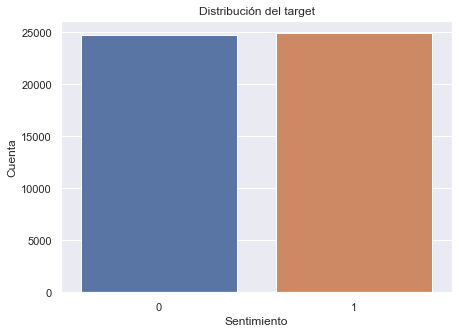

In [6]:
plt.figure(figsize=(7,5))

# Countplot genera un gráfico de barras con tantas barras como
# categorías tome la variable indicada, y representa el conteo.
sns.countplot(x='sentiment', 
              data=datos)

# Títulos y etiquetas
plt.title('Distribución del target')
plt.xlabel('Sentimiento')
plt.ylabel('Cuenta');

In [7]:
# Calculamos la proporción de sentimientos positivos (codificados con un 1)
# sumando la columna y dividiendola por el total
datos.sentiment.sum() / len(datos) 

0.5018756806905732

Las clases de la variable dependiente están prácticamente en perfecto equilibrio, el dataset cuenta con aproximadamente el mismo número de reseñas positivas que negativas, así que no será necesario aplicar técnicas para equilibrarlo. A continuación comenzamos el preprocesado y limpieza

## Preprocesado

Trabajaremos solo con la columna de review, puesto que es la que contiene el texto, así que la aislamos por simplificar el trabajo.

In [4]:
texto = datos.review

El método de trabajo que se aplica es el siguiente:

1. Se generan las funciones individuales que se ocupan de cada una de las tareas de limpieza, de manera individual. 
2. Se engloban todas esas funciones en una función general, que realice todos los pasos de manera secuencial, para cada una de las reseñas del dataset. 

En el flujo de trabajo del proyecto, las funciones se van probando con una muestra de una sola reseña, pero este proceso queda fuera de la versión final del notebook.

Primero es necesario pasar el texto a minúsculas, puesto que la misma palabra, comenzando en mayúscula y comenzando en minúscula, se registraría como dos palabras distintas, y queremos evitar qu eso suceda. Para este paso no declaramos una función, por la sencillez del proceso, pero la operación se realizará de la siguiente manera

In [225]:
texto = texto.map(lambda x: x.lower())
texto.head()

0    although this film was made before dogme emerg...
1    my grandmother took me and my sister out to se...
2    possibly the worst film within the genre in ex...
3    as long as you keep in mind that the productio...
4    the plot in petites coupures certainly left th...
Name: review, dtype: object

### Caracteres HTML

Para tratar el texto en general y hacer operaciones de sustitución, se utiliza el paquete `re`, que sirve para trabajar con expresiones regulares. El planteamiento es el mismo para todas las operaciones:

1. Se escribe el patrón de caracteres que se desea identificar en cada reseña con `re.compile`
2. Se elimina del texto, sustituyendolo por una string vacía, utilizando `re.sub`

In [5]:
def limpiar_html(texto):
    patron_html = re.compile('<.*?>') # caracteres html
    texto = patron_html.sub('', texto) # eliminación de los caracteres
    return texto

### Limpieza de emoticonos

Se utilizan las expresiones regulares referentes a una amplia gama de emoticonos, disponibles [aquí](https://apps.timwhitlock.info/emoji/tables/unicode)

In [6]:
def limpiar_emoticonos(texto):
    
    # Se define el patrón de emoticonos
    patron_emojis = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticonos generales
                               u"\U0001F300-\U0001F5FF"  # símbolos
                               u"\U0001F680-\U0001F6FF"  # transportes
                               u"\U0001F1E0-\U0001F1FF"  # banderas
                               u"\U00002500-\U00002BEF"  # letras chinas
                               u"\U00002702-\U000027B0"  # resto de emoticonos...
                                u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", 
                               flags=re.UNICODE) # hay que especificar que son unicode
    
    # Se eliminan del texto
    texto = patron_emojis.sub('', texto)
    return texto

### Limpieza de  URL's

Se define una función que elimina cualquier rastro de enlaces a páginas web

In [7]:
def limpiar_url(texto):
    
    # Patrón para los caracteres de URL's
    patron_url = re.compile('https://\S+|www\.\S+')
    
    # Eliminación del patrón
    texto = patron_url.sub('', texto)
    return texto

### Limpieza de signos de puntuación

Los signos de puntuación tampoco son interesantes, puesto que de manera aislada carecen de sentido.

In [8]:
def limpiar_puntuacion(texto):
    
    # Se define el patrón para eliminar los signos de puntuación
    patron_puntuacion = re.compile('[^\w\s]')
    
    # Se eliminan del texto
    texto = patron_puntuacion.sub('', texto)
    
    # Se unifican las reseñas en un único texto para facilitar la lematizacion y tokenizacion
    texto = ''.join(texto)
    return texto

### Lematizacion y stopwords

Las __stopwords__ son aquellas palabras que no transmiten ningún significado. Por ejemplo: "con", "es", "y" en castellano, o para el caso del trabajo, en inglés "me", "that", "you", "I", etc. Después de eliminar estas palabras de una frase, nos quedamos con un conjunto de palabras sueltas, también denominado 'bag of words' o bolsa de palabras. Estas palabras pueden ser de cualquier forma. Pueden estar en tiempo pasado, en tiempo presente... Para llevar la palabra a su forma base, hay dos técnicas. *'Stemming'* (derivar) y *'lemmatizing'* (lematizar). Nosotros utilizaremos la lematización.

La __lematización__ es una técnica de normalización de textos o palabras en el campo del procesamiento del lenguaje natural que se utiliza para preparar textos, palabras y documentos para su posterior procesamiento. La lematización consiste volver a la palabra raíz mediante la extracción del 'lemma'. Este proceso es muy importante ya que permite que las palabras lematizadas puedan analizarse como un sólo elemento, identificado por el lema de la palabra. Un ejemplo sencillo sería el paso de "unbelievable" a "believe"

Definimos una función que realice ambas tareas.

In [9]:
def lematizacion_y_stopwords(texto):
    
    # Se inicializa el lematizador, que extraerá la palabra raíz de cada 
    # una de las palabras
    lematizador = WordNetLemmatizer() 
    
    # Se utiliza una list comprehension para hacer un loop:
    # Se genera una lista que contiene cada una de las palabras del texto, lematizadas, si 
    # estas no forman parte de las stopwords inglesas
    texto = [lematizador.lemmatize(palabra) for palabra in texto.split() # split para tenerlo por palabras
                                                        if palabra not in stopwords.words('english')]
    
    # Se unifican las palabras, esta vez por espacios
    texto = ' '.join(texto)
    
    return texto

### Tokenizar 

La __tokenizacion__ consiste en dividir una frase, oración, párrafo o un documento de texto completo en unidades más pequeñas, donde cada una de estas unidades más pequeñas se denominan 'tokens'.
Este procedimiento es realmente importante debido a la flexibilidad y funcionalidad que aporta a la hora de análizar texto. Algunos ejemplos de uso son:
* Conteo del número total de palabras en texto
* Frecuencia con la que una palabra aparece en el texto

No obstante, este proceso se llevará a cabo en la siguiente fase del trabajo. Se incorporará a los modelos en forma de pipeline, puesto  que es el propio vectorizador (explicación en el siguiente notebook) el que realiza este proceso.

##  Función general, preprocesa todo el texto raw

Se agrupan todos los pasos anteriores en una sola función. De este modo, se compacta el preprocesado, y es más fácil utilizarlo con texto sin preprocesar

In [11]:
def preprocesar_texto(texto):
    
    # Dado un texto, se aplican secuencialmente los pasos ya definidos
    texto = texto.lower() # el paso para el que mencionabamos que no se definía función
    texto = limpiar_html(texto)
    texto = limpiar_emoticonos(texto)
    texto = limpiar_url(texto)
    texto = limpiar_puntuacion(texto)
    texto = lematizacion_y_stopwords(texto)
    
    # y se devuelve el texto limpio
    return texto

Aplicamos la función sobre todos los datos. Hay que utilizar `.map`, puesto que las funciones están programadas para ejecutarse solo sobre una reseña, y queremos procesar todas.

In [14]:
texto_limpio = texto.map(preprocesar_texto)

Lo añadimos al dataframe original

In [14]:
datos['texto_limpio'] = texto_limpio

La columna de la izquierda muestra el texto sin preprocesar, y la de la derecha el resultado tras aplicar el preprocesado

In [16]:
datos[['review', 'texto_limpio']].head(10)

,review,texto_limpio
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...
5,"Probably my all-time favorite movie, a story o...",probably alltime favorite movie story selfless...
6,I sure would like to see a resurrection of a u...,sure would like see resurrection dated seahunt...
7,"This show was an amazing, fresh & innovative i...",show amazing fresh innovative idea 70 first ai...
8,Encouraged by the positive comments about this...,encouraged positive comment film looking forwa...
9,If you like original gut wrenching laughter yo...,like original gut wrenching laughter like movi...


Vemos como todo el texto está en minúsclas, se han elimiado las stopwords como los pronombres, la notación html ha desparecido y símbolos como & o comillas ya no están en el texto. Eliminamos la columna con el texto raw, revisamos los datos limpios y los guardamos en su correspondiente carpeta.

In [19]:
datos.drop(['review'], axis=1, inplace=True) # fuera el texto raw

In [20]:
# Estos son los datos limpios 
datos.head()

,sentiment,texto_limpio
0,1,one reviewer mentioned watching 1 oz episode y...
1,1,wonderful little production filming technique ...
2,1,thought wonderful way spend time hot summer we...
3,0,basically there family little boy jake think t...
4,1,petter matteis love time money visually stunni...


Antes de guardar los datos, renombramos la columna de las reviews para que se llame igual que los datos raw, puesto que ahora se llama "texto_limpio". Es crucial que las variables con las que los modelos entrenan se llamen igual que las variables que el modelo recibiría en producción, de lo contrario, el sistema caería, provocando pérdidas inadmisibles para la empresa.

In [21]:
datos.rename(columns={'texto_limpio':'review'}, inplace=True)

Los datos se guardan con `pickle` en formato `.sav`, que utiliza notación binaria, y asegura que no haya ninguna modificación en los datos, como sí podría suceder si se guardasen en formato `.csv`.

In [22]:
# Guardamos los datos
datos.to_pickle('../data/clean/clean_data.sav')

## Análisis exploratorio

Con los datos ya limpios, intentamos ampliar un poco la exploración, para tratar de sacar algunas conclusiones previas a los modelos que podamos contrastar al final del proyecto

###  Wordcloud

Las "wordcloud" son representaciones gráficas habituales empleadas con texto. Se trata de nubes de palabras, donde se representan las palabras que más aparecen en un determinado texto. Sirven para tener una idea previa de cuáes pueden ser las palabras más importantes en un texto. 

Con el fin de representar cuáles podrían ser las palabras más representativas en las clases positivas y negativas, realizamos dos wordcloud, uno para cada clase.

Primero cremos dos subconjuntos, uno con las reviews positivas y otro con las negativas. Recordemos que el 1 representa la clase positiva, y el 0 la negativa

In [25]:
reviews_positivas = datos.review[datos.sentiment == 1]
reviews_negativas = datos.review[datos.sentiment == 0]

In [26]:
# Hay que unir las reviews en un solo texto
texto_reviews_positivas = ' '.join(reviews_positivas)
texto_reviews_negativas = ' '.join(reviews_negativas)

Definimos dos funciones, una que cree la imagen con la nube de palabras, y otra que haga el plot de dicha imagen.

In [28]:
def crear_wordcloud(texto, color_fondo, color_palabras):
    wordcloud = WordCloud(width=3000, # dimensiones de la imagen 
                          height=2000, 
                          random_state=1234, # para poder replicar el resultado
                          background_color=color_fondo, # parametros para poder modificar los colores
                          colormap=color_palabras,
                          collocations=False).generate(texto) # el generador de la nube
    return wordcloud

In [29]:
def plot_cloud(wordcloud):
    # Tamaño de la imagen
    plt.figure(figsize=(15, 7))
    
    # Mostrar la imagen
    plt.imshow(wordcloud) 
    
    # Eliminamos los ejes, porque no son necesarios 
    plt.axis("off");

Aplicamos cada una de las funciones a las clases positivas y negativas

In [30]:
# Primero para las positivas: generamos la nube
wordcloud_positivas = crear_wordcloud(texto_reviews_positivas, 
                                       color_fondo='blue', 
                                       color_palabras='Pastel1')

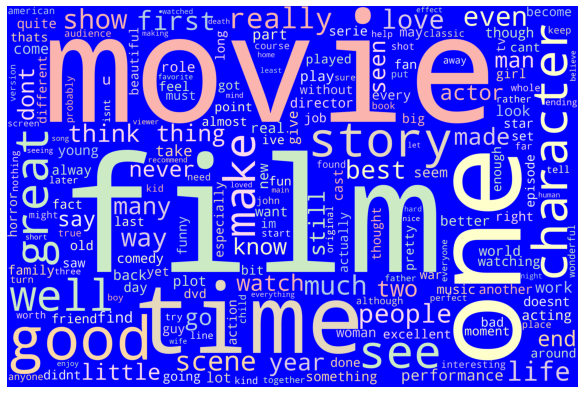

In [31]:
# Representamos la imagen
plot_cloud(wordcloud_positivas)

In [53]:
# Mismo procedimiento con las negativas
wordcloud_negativas = crear_wordcloud(texto_reviews_negativas, 
                                       color_fondo='salmon', 
                                       color_palabras='Pastel1')

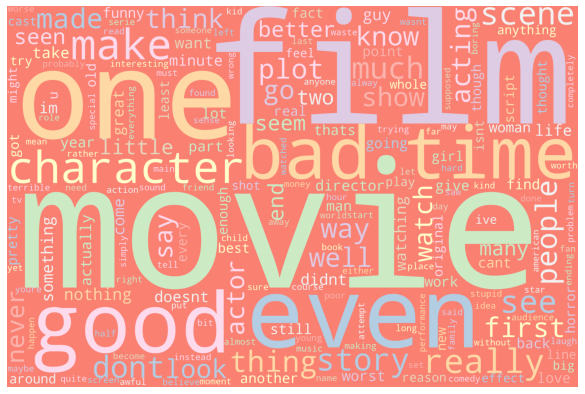

In [54]:
plot_cloud(wordcloud_negativas)

Vemos que en ambas clases las palabras _movie_ y _film_ son las más frecuentes. Esto se debe a que son palabras propias del ámbito cinematográfico, y el contador que utilza wordcloud no lo tiene en cuenta. De cara a los modelos, utilizaremos el __Tfidf__ (explicación en el siguiente notebook) para tratar de solventar esto.

No obstante, vemos como en la nube de palabras de reviews positivas aparecen palabras como _love, good time, well_, etc. La mayoría de palabras son positivas y afirmativas.

Análogamente, en la nube de las reviews negativas, se pueden observar palabras como _dont look, never, bad time_ y _worst_, entre otras.

Será interesatne contrastar estos resultados preliminares con el análisis del modelo final, y las variables más importantes.

## VADER (Valence Aware Dictionary and sEntiment Reasoner)

VADER es una herramienta de text mining, específica para el campo de análisis de sentimientos, especializada en el análisis de texto procedente de redes sociales. Utiliza reglas gramaticales para asignar puntuaciones numéricas a texto, y tratar de cuantificar los sentimientos. Para un determinado texto, VADER cuantifica la positividad, negatividad, neutralidad y polaridad de dicho texto. La herramienta es sencilla y puede emplearse con distintos fines, como los que expondremos a continuación. No obstante, hay que tener en cuenta dos aspectos cruciales de VADER:

- No es un clasificador como tal, y por ende no es posible medir su rendimiento con las métricas que se utilizan en aprendizaje supervisado. Podría catalogarse como una técnica de aprendizaje no supervisado, o semi-supervisado

- Tiene la gran ventaja de trabajar con texto prácticamente raw, el tratamiento que hay que aplicar a los datos es mínimo y en ocasiones opcional. Al contrario que para los modelos habituales, no es necesario eliminar capitalización, emoticonos ni signos de puntuación, puesto que VADER los entiende y considera en su proceso. Esto lo convierte en una herramienta rápida de preparar, idónea para análisis exploratorio, y diseñada específicamente para sentimientos.

A continuación se realiza una pequeña demostración de su manejo, y después se aplica al caso de uso.

##### Ejemplo simple

Como comentábamos, la herramienta trabaja sobre texto casi raw. Podemos definir una función más simple, con menos preprocesado, y tratar los datos raw de manera mas superficial, eliminando solo los caracteres extraños. Volvemos a cargar los datos raw y creamos la función

In [18]:
datos_raw = pd.read_csv('../data/raw/imdb.csv')

In [19]:
def preprocesar_texto_ligero(texto):
    
    # La función emplea parte del preprocesado anterior
    texto = limpiar_html(texto)
    texto = limpiar_url(texto)
    
    return texto

Volvemos a quitar los duplicados

In [20]:
datos_raw.drop_duplicates(inplace=True)

In [21]:
# Limpiamos la columna aplicando la función
datos_raw.review = datos_raw.review.map(preprocesar_texto_ligero)

Este es el resultado de la limpieza superficial

In [22]:
datos_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Los datos están preparados para usarse con VADER. Inicializamos el calculador de polaridad.

In [23]:
vader = SentimentIntensityAnalyzer()

Probamos el analizador, primero con una sola review. Es posible analizarla en conjunto o por frases

In [24]:
review = datos_raw.review[9]
review

'If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.Great Camp!!!'

La dividimos para analizarla por frases

In [25]:
frases_review = review.split('.') # crea una lista donde cada elemento es el resultado de dividir la review
                                  # por puntos 
frases_review

['If you like original gut wrenching laughter you will like this movie',
 ' If you are young or old then you will love this movie, hell even my mom liked it',
 'Great Camp!!!']

Aplicamos VADER a cada una de las frases. Los resultados de VADER son de la forma
- __neg__: negatividad de la frase
- __neu__: neutralidad de la frase
- __pos__: positividad de la frase
- __compound__: métrtica agregada que varía entre -1 y 1, que mide la polaridad. Valores cercanos a -1 indican fuerte negatividad, y valores cercanos a 1 fuerte positividad

In [27]:
for frase in frases_review:
    print('')
    print(frase)
    print(vader.polarity_scores(frase)) # la puntuacion se calcula con polarity scores
    


If you like original gut wrenching laughter you will like this movie
{'neg': 0.0, 'neu': 0.432, 'pos': 0.568, 'compound': 0.8591}

 If you are young or old then you will love this movie, hell even my mom liked it
{'neg': 0.173, 'neu': 0.564, 'pos': 0.263, 'compound': 0.34}

Great Camp!!!
{'neg': 0.0, 'neu': 0.167, 'pos': 0.833, 'compound': 0.7163}


Vemos como los signos de puntuación, como los de exclamación, son importantes en VADER, puesto que contienen significado. En este caso, el modelo asigna alta positvididad a la frase con las exclamaciones. El análisis también se puede relizar con toda la review, en cuyo caso las puntuaciones se asignan de manera conjunta

In [28]:
vader.polarity_scores(review)

{'neg': 0.098, 'neu': 0.511, 'pos': 0.391, 'compound': 0.9149}

El resultado agregado es coherente con el resultado por frases. VADER asigna alta positividad a la review

Ahora empleamos VADER sobre todo nuestro dataset, generando cuatro columnas más, una para cada nueva variable para todas las reseñas

In [31]:
puntuaciones_polaridad = datos_raw.review.map(vader.polarity_scores) # calculamos la polaridad

In [32]:
# Creamos 4 nuevas columnas, una con cada uno de los valores que devuelve VADER
datos_raw['negatividad'] = puntuaciones_polaridad.map(lambda x: x['neg'])
datos_raw['neutralidad'] = puntuaciones_polaridad.map(lambda x: x['neu'])
datos_raw['positividad'] = puntuaciones_polaridad.map(lambda x: x['pos'])
datos_raw['polaridad'] =  puntuaciones_polaridad.map(lambda x: x['compound'])

In [33]:
# Resultado
datos_raw.head()

,review,sentiment,negatividad,neutralidad,positividad,polaridad
0,One of the other reviewers has mentioned that ...,positive,0.207,0.744,0.049,-0.9951
1,A wonderful little production. The filming tec...,positive,0.055,0.768,0.177,0.9641
2,I thought this was a wonderful way to spend ti...,positive,0.096,0.708,0.196,0.9605
3,Basically there's a family where a little boy ...,negative,0.144,0.788,0.068,-0.9213
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.053,0.795,0.152,0.9744


Esto puede tener distintas utilidades, las cuales se exponen a contuniación.

## Soporte para el análisis exploratorio

Esta es la función que le damos nosotros en este trabajo. Al trabajar con datos de texto, los cálculos exploratorios se complican y se vuelven casi inviables. Además, la densidad del texto hace que el problema se complique aún más.

Sin embargo, el análisis se puede ampliar utilizando VADER. Al devolver puntuaciones, en lugar de categorías, es posible "cuantificar" el sentimiento (entre comillas por la subjetividad de dicha tarea). Esto permite hacer cálculos descriptivos sobre el dataset, para tener unas métricas preliminares que resuman las reviews. No obstante, hay que tener precaución con estos resultados, puesto que la regla con la que se han etiquetado los datos originalmente no tiene por qué coincidir con VADER, como veremos más adelante.

In [41]:
# Podemos hacer un describe
sentimientos_vader = datos_raw[['negatividad', 'neutralidad', 'positividad', 'polaridad']]
sentimientos_vader.describe()

,negatividad,neutralidad,positividad,polaridad
count,49582.000000,49582.000000,49582.000000,49582.000000
mean,0.095191,0.762993,0.141818,0.301115
std,0.059053,0.069278,0.066911,0.803945
min,0.000000,0.336000,0.000000,-0.999800
25%,0.052000,0.720000,0.095000,-0.680475
50%,0.088000,0.766000,0.132000,0.818100
75%,0.130000,0.810000,0.179000,0.969800
max,0.580000,1.000000,0.548000,0.999900


Hay que tener cuidado al comparar los datos, puesto que la polaridad no está en la misma escala que el resto de indicadores, y la neutralidad, pese a estar en la misma escala, no se mueve en los mismsos rangos que la positividad y la negatividad.

Se puede observar que tanto la negatividad como la positividad tienen estadísticos similares en nuestro dataset. Con una representación gráfica, la similaridad se aprecia mejor.

In [42]:
# Pasamos los datos a formato largo: solo nos interesa la negativida y la positividad, porque es lo único que 
# existe en nuestro label original
sentimientos_formato_largo = sentimientos_vader[['negatividad', 'positividad']].melt()

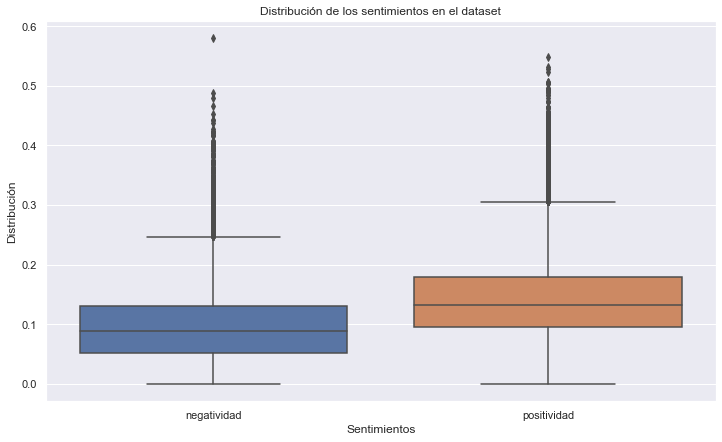

In [44]:
# Hacemos los plots
plt.figure(figsize=(12, 7))

# Boxplot de las distribuciones de la positividad y negatividad
sns.boxplot(x='variable', # cada una de las clases 
            y='value', # su valor 
            data=sentimientos_formato_largo)

# Titulos y etiquetas
plt.title('Distribución de los sentimientos en el dataset')
plt.xlabel('Sentimientos')
plt.ylabel('Distribución');

La positividad tiene una distribución que tiende hacia valores ligeramente más elevados que la negatividad, pero por lo demás, ambas son muy similares.

Analicemos ahora la polaridad

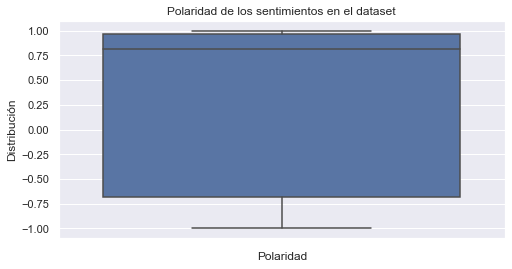

In [47]:
# Dimensiones
plt.figure(figsize=(8, 4))

# El boxplot de la polaridad
sns.boxplot(y=sentimientos_vader['polaridad'])

# Titulos y etiquetas
plt.title('Polaridad de los sentimientos en el dataset')
plt.xlabel('Polaridad')
plt.ylabel('Distribución');

El boxplot no es muy sugerente. Para una mejor representación, podemos recurrir al histograma.

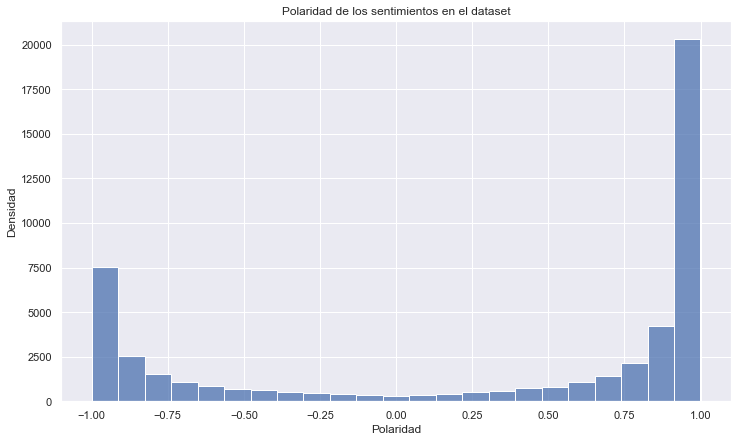

In [48]:
# Tamaño del gráfico
plt.figure(figsize=(12, 7))

# Histrograma de la polaridad
sns.histplot(sentimientos_vader['polaridad'])

# Títulos y etiquetas
plt.title('Polaridad de los sentimientos en el dataset')
plt.xlabel('Polaridad')
plt.ylabel('Densidad');

Se pueden distinguir claramente dos grupos diferenciados del resto, en cada extremo del histograma, lo que revela que los sentimientos están bastante polarizados en nuestro dataset. Este hecho pone de manifiesto que la mejor manera de afrontar este problemna es probablmente con clasificación binaria, reservando una clase para cada polo. No parece coherente tratar de generar más clases.

### Aumentar el grado de detalle de la clasificación

Como se acaba de exponer, en el caso de uso que ocupa a este trabajo, los sentimientos están muy polarizados, pero podría suceder que no hubiese tanta polaridad, y hubiese un grupo intermedio en el  histrograma, que propiciase la creación de un tercer grupo. Podría ser que la etiqueta binara positiva/negativa fuese demasiado generalista, y que se necesitase un tercer grupo. En este caso, se podría utilizar VADER para generar una nueva categoría.

__Nota__: pese a que a continuación se entrena un pequeño modelo, esta parte no corresponde al modelado de nuestro trabajo, es solo para ilustrar cómo se pondrían en práctica los dos ejemplos que se comentan.

Bastaría con definir un criterio sobre la polaridad, que incluyese tres categorías, de la siguiente manera

In [49]:
def categoria_vader(polaridad):
    
    # Categoria para la positividad: superiores a 0.5
    if(polaridad > 0.5):
        return 'positive'
    
    # Categoría para la neturalidad: menor o igual que 0.5 y mayor o igual que -0.5
    elif(polaridad <= 0.5 and polaridad >= -0.5):
        return 'neutral'
    
    # Categoría para la negatividad: menores que -0.5 (el resto)
    else:
        return 'negative'

Aplicamos la función sobre los datos para crear una nueva columna, con el target de VADER

In [50]:
datos_raw['target_vader'] = datos_raw.polaridad.map(categoria_vader)

Comparamos ambos target y mostramos 15 reviews

In [52]:
datos_raw[['review', 'sentiment', 'target_vader']].head(15)

,review,sentiment,target_vader
0,One of the other reviewers has mentioned that ...,positive,negative
1,A wonderful little production. The filming tec...,positive,positive
2,I thought this was a wonderful way to spend ti...,positive,positive
3,Basically there's a family where a little boy ...,negative,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,positive
5,"Probably my all-time favorite movie, a story o...",positive,positive
6,I sure would like to see a resurrection of a u...,positive,positive
7,"This show was an amazing, fresh & innovative i...",negative,positive
8,Encouraged by the positive comments about this...,negative,neutral
9,If you like original gut wrenching laughter yo...,positive,positive


A partir de aquí se podría construir un modelo de clasificacion multiclase para predecir el sentimiento de las reseñas. A continuación se muestra un pequeño ejemplo del procedimiento

In [53]:
# Division de los datos en los tres tramos habituales
train, validation, test = np.split(datos_raw.sample(frac=1, random_state=1234), 
                                   [int(0.6*len(datos_raw)),
                                    int(0.8*len(datos_raw))])

In [54]:
# Creación de los objetos
# Tramo de entrenamiento 
X_train = train.review
y_train = train.target_vader

# Tramo de validacion 
X_validation = validation.review
y_validation = validation.target_vader

# Tramo de test
X_test = test.review
y_test = test.target_vader

Un posible modelo que podría aplicar la empresa sería el siguiente

In [55]:
modelo_perceptron = Pipeline(steps=[
    
    ('vectorizador', TfidfVectorizer()),
    
    ('clasificador', Perceptron())
])

In [56]:
np.random.seed(1234)
modelo_perceptron.fit(X_train, y_train) # ajuste del modelo 
modelo_perceptron.score(X_test, y_test) # accuracy en test

0.7409498840375114

Para mejorar los resultados, sería aconsejable limpiar más en profundidad los datos, puesto que el preprocesado que se efectúa para utilizar VADER es bastante ligero, algo que puede empeorar los resultados del modelo

### Etiquetar los datos 

Finalmente, una tercera forma de generar valor utilizando VADER sería el etiquetado de los datos, una tarea crucial para el proceso de Machine Learning. Es habitual la situación en la que una empresa solo cuenta con las reviews de sus usarios, pero no con las etiquetas que determinen si estas son postivias o negativas. En ese caso, podría utilizar VADER para generar etiquetas y clases de manera análoga a como se acaba de demostrar para el caso muilticlase. De nuevo, utilizando la puntuación de la polaridad, se puede definir una regla más generalista que la anterior para generar dos clases.

El procedimiento sería el siguiente :
1. Recogida y limpieza mínima de los datos
2. Aplicación de VADER para obtener los valores de polaridad
3. Crecaión del criterio a partir del cual se definen las categorías
4. Aplicación de modelos sobre los datos etiquetados

Definimos la regla binaria y la aplicamos a los datos creando la nueva columna

In [57]:
def categoria_vader_binaria(polaridad):
    
    # Caso de las positivas
    if (polaridad > 0):
        return 'positive'
    
    # Caso de las negativas
    else:
        return 'negative'

In [58]:
datos_raw['target_vader_binario'] = datos_raw.polaridad.map(categoria_vader_binaria)

In [59]:
datos_raw[['target_vader_binario']]

,target_vader_binario
0,negative
1,positive
2,positive
3,negative
4,positive
...,...
49995,positive
49996,negative
49997,negative
49998,negative


Y a partir de aquí se construirían los modelos, como antes. Hay que repetir la división porque ahora se utiliza otra columna

In [62]:
# Se dividen los datos
train, validation, test = np.split(datos_raw.sample(frac=1, random_state=1234), 
                                   [int(0.6*len(datos_raw)),
                                    int(0.8*len(datos_raw))])

In [63]:
# Se crean los objetos
# Tramo de entrenamiento 
X_train = train.review
y_train = train.target_vader_binario

# Tramo de validacion 
X_validation = validation.review
y_validation = validation.target_vader_binario

# Tramo de test
X_test = test.review
y_test = test.target_vader_binario

In [64]:
np.random.seed(1234)

modelo_perceptron.fit(X_train, y_train)
modelo_perceptron.score(X_test, y_test)

0.8193001915901986

El accuracy mejora algo en el caso binario, lo que podría ser un sínmtoma de que los datos en este problema deban ser tratados de manera binaria, o simplemente un indicador de que el problema binario es más fácil de resolver que el multiclase

Por último, podemos comprobar el label original de los datos con el que acabamos de generar con VADER

In [65]:
coincidencia = np.sum(datos_raw.sentiment == datos_raw.target_vader_binario) # suma las veces que coinciden los target
discrepancia = len(datos_raw) - coincidencia 

print('Coincidencia de etiquetas:', coincidencia)
print('Discrepancia de etiquetas:', discrepancia)

Coincidencia de etiquetas: 34518
Discrepancia de etiquetas: 15064


Vemos como de aproximadamente 50.000 datos, 34518 han sido etiquetados igual en VADER que en la etiqueta original de los datos, y los restantes no. Esto podría deberse a que los datos originales se etitquetaron siguiendo otros criterioos.

Con esto conlcuye el preprocesdo y el análisis exploratorio de los datos. En el siguiente notebook se construyen los distintos modelos.